## TP4 - Léa Heiniger

In [1]:
## imports
import numpy as np
import math
import random
from copy import copy
import matplotlib.pyplot as plt
from time import time
from collections import OrderedDict
import statistics

### PART 1 - Monday, October 31, 2022

In [2]:
def cities_coordinates(filename):
    '''
    read .dat file and return a dictionary of cities' coordinates

    Parameters:
    -----------
    filename

    Returns:
    --------
    d_c : dictionary of cities' coordinates in form k:v
    where k is the city name
    & v are the coordinates (x, y)
    '''
    cities = []
    coordinates = []
    with open(filename, "r") as f:
        for l in f:
            line = list(filter(None, l.rstrip().split(' ')))
            cities.append(line[0])
            coordinates.append((float(line[1]), float(line[2])))
    d_c = {k: v for (k, v) in zip(cities, coordinates)}
    return d_c

In [3]:
# compute distances between all points, and store into a dictionary
def compute_distances(setting):
    # TODO
    '''
    compute the distances between all points of a setting (coordinates of cities)

    Parameters:
    -----------
    setting : dictionary of cities' coordinates in form k:v
    where k is the city name
    & v are the coordinates (x, y)

    Returns:
    --------
    dist : a dictionary of distances between all points (c1, c2) in the setting
    NOTE: 
    1. You can implement by computing the distances everytime, but since the distance between 2 cities will be needed frequently, 
    this step saves computations.
    2. In case you use this dictionary implementation, remember that distance(c1, c2) = distance(c2, c1) --> even less calculations (but more memory !)
    '''
    dist = {}
    cityNames = list(setting.keys())
    
    for i in range(len(cityNames)-1) :
        for j in range(i+1,len(cityNames)):
            
            (x1, y1) = setting[cityNames[i]]
            (x2, y2) = setting[cityNames[j]]
            
            d = math.sqrt((x2-x1)**2 +(y2-y1)**2)
            
            dist[cityNames[i]+cityNames[j]] = d
            dist[cityNames[j]+cityNames[i]] = d
            
    return dist
        
    
 
# compute fitness by computing length of the path    
def compute_fitness(combination, dist):
    # TODO
    '''
    compute path length of a combination (of cities)

    Parameters:
    -----------
    combination : list of cities' path
    dist : a dictionary of distances between all points (c1, c2) in the setting

    Returns:
    --------
    fitness : path length
    '''
    fitness = 0
    
    for i in range(len(combination)) :
        fitness += dist[combination[i-1]+combination[i]]
    

        
    return fitness

# compute the probability of choosing a next city from unvisited cities
def prob_to_city(i, j, J, dist, T, alpha = 1, beta = 5):
    # TODO
    '''
    compute the probability of moving from city i to city j (j belongs to J)

    Parameters:
    -----------
    i : current city
    j : city belonging to J 
    J : list of unvisited cities
    dist : a dictionary of distances between all points (c1, c2) in the setting
    T : dictionary of pheremone quantities between points (c1, c2)
    alpha : parameter that controls the relative importance of the pheromone
    beta : parameter that controls the relative importance of the heuristic information η_ij

    Returns:
    --------
    p : probability to go to city j from city i
    '''
    s = 0
    for l in J :
        s += (T[i+l]**alpha)*((1/dist[i+l])**beta)
    
    p = ((T[i+j]**alpha)*((1/dist[i+j])**beta))/s
    return p
    

In [4]:
def closest(city, cityNames, dist) :
    '''
    Function that finds in a list of city names the closest city from a chosen city

    Parameter(s) :
     city -> the name of the chosen city 
     cityNames -> a list of city names
     dist -> a dictionary of ditances between all cities

    Returning :
     closestCity -> the name of the closest city
    '''
    lNames = copy(cityNames)
    closestCity = lNames.pop()
    
    for c in lNames :
        if dist[city+c]<dist[city+closestCity]:
            closestCity = c
            
    return closestCity

# find solution by greedy algorithm
def find_greedy(setting, dist):
    # TODO
    '''
    perform the greedy algorithm

    Parameters:
    -----------
    setting : dictionary of cities' coordinates in form k:v
    where k is the city name
    & v are the coordinates (x, y)
    dist : a dictionary of distances between all points (c1, c2) in the setting

    Returns:
    --------
    c : path (list)
    fitness : fitness of path
    exec_time : execution time
    '''
    start = time()
    
    cityNames = list(setting.keys())
    city = cityNames.pop(0)
    c = [city]
    
    while len(cityNames)>0 :
        closestCity = closest(city, cityNames, dist) # at each step we chose the closest city
        city = closestCity
        c.append(cityNames.pop(cityNames.index(city)))
    
    fitness = compute_fitness(c, dist)
    
    stop = time()
    exec_time = stop-start
    
    return c, fitness, exec_time

In [5]:
def roulette_method(P) :
    '''
    Function implementing the roulette method

    Parameters :
     P -> the probability of obtaining each event

    Returning :
     The event obtained
    '''
    Pcumul = [sum(P[0:x:1]) for x in range(0, len(P)+1)]
    Pcumul.pop(0)
    r = random.random()
    for i in range(len(Pcumul)) :
        if Pcumul[i] > r :

            return i

# path of each individual ant (run later in parallel, independent at each time t)
def ant_path(setting, dist, T, alpha = 1, beta =5):
    # TODO
    '''
    path of each individual ant (out of m ants)
    this function can be parallelized and used later in the main AS function

    Parameters:
    -----------
    setting : dictionary of cities' coordinates in form k:v
    where k is the city name
    & v are the coordinates (x, y)
    dist : a dictionary of distances between all points (c1, c2) in the setting
    T : dictionary of pheremone quantities between points (c1, c2)
    alpha : controls the relative importance of the pheromone
    beta : controls the relative importance of the heuristic information η_ij

    Returns:
    --------
    c : path (list)
    fitness : fitness of path
    '''
    J = list(setting.keys())
    city = J.pop(math.floor(random.random()*len(J))) # we choose a random city
    c = [city]
    
    while len(J)>0 :
        # we compute the probability for each unvisited city
        P = [prob_to_city(city, j, J, dist, T, alpha, beta) for j in J] 
        
        nextCity = J.pop(roulette_method(P))
        c.append(nextCity)
        city = nextCity
                
        
    fitness = compute_fitness(c, dist)
    
    return c, fitness

##### NOTE: Completing the AS algorithm (function find_AS) is included in Part 2 of this TP (due Nov 7th), thus will not be part of the evaluation for Part 1. However, it is highly advised to try to work on it during TP4 Part1 if time permits, so that we can give feedback to aid for Part 2. 

### PART 2 - Monday, November 7, 2022

In [6]:
def init_T(setting, tau0) :
    '''
    Function that initialize T

    Parameters:
     setting -> dictionary of cities
     tau0 -> the value to whichwe intialise all tau_ij

    Returns:
     T -> dictionary with all tau_ij = tau0
    '''
    T = {}
    cityNames = list(setting.keys())
    
    for i in range(len(cityNames)-1) :
        for j in range(i+1,len(cityNames)):
            
            T[cityNames[i]+cityNames[j]] = tau0
            T[cityNames[j]+cityNames[i]] = tau0
            
            
    return T
    
def init_pheromones(setting) :
    '''
    Function that creates a pheromones dictionary

    Parameters:
     setting -> dictionary of cities

    Returns:
     pheromones -> dictionary with all values to zero
    '''
    pheromones = {}
    cityNames = list(setting.keys())
    
    for i in range(len(cityNames)-1) :
        for j in range(i+1,len(cityNames)):
            
            pheromones[cityNames[i]+cityNames[j]] = 0
            pheromones[cityNames[j]+cityNames[i]] = 0
            
            
    return pheromones


def update_pheromones(pheromones, c, fitness, Q) :
    '''
    Function that updates the pheromones dictionary according to a path c

    Parameters:
     pheromones -> dictionary of pheromones
     c -> a path
     fitness -> the fitness of c
     Q -> a constant

    Returns:
     pheromones -> dictionary of pheromones updated
    '''
    
    for i in range(len(c)) :
        pheromones[c[i-1]+c[i]] += Q/fitness
        
    return pheromones


def update_T(T, pheromones, rho=0.1) :
    '''
    Function that updates the dictionary T according to all paths marked

    Parameters:
     T -> the dictionary of pheromones 
     pheromones -> dictionary of pheromones
     rho -> a constant (evaporation rate)

    Returns:
     T -> dictionary T updated
    '''
    keys = list(pheromones.keys())
    
    for key in keys :
        T[key] = (1-rho)*T[key]+pheromones[key]
        
    return T
    
    
# find solution by Ant System Algorithm
def find_AS(setting, g_fitness, dist, tmax, ants, alpha=1, beta=5):
    # TODO
    '''
    perform the Ant System algorithm

    Parameters:
    -----------
    setting : dictionary of cities' coordinates in form k:v
    where k is the city name
    & v are the coordinates (x, y)
    g_fitness : fitness that we get from greedy algorithm (best one)
    dist : a dictionary of distances between all points (c1, c2) in the setting
    t_max : number of iterations 
    ants : number of ants
    alpha : controls the relative importance of the pheromone
    beta : controls the relative importance of the heuristic information η_ij

    Returns:
    --------
    c : path (list)
    fitness : fitness of path
    exec_time : execution time

    NOTE : the function ant_path can be parallelized, since at each iteration, ants are independent
    '''
    start = time()
    
    Lnn = g_fitness
    roh = 0.1
    Q = Lnn
    tau0 = 1/Lnn
    T = init_T(setting, tau0)
    
    bestPath = []
    bestFit = np.inf
    
    for t in range(tmax) :
        
        pheromones = init_pheromones(setting)
        paths = []
        fit = []
        
        for k in range(ants) :
            
            c, fitness = ant_path(setting, dist, T, alpha, beta)
            paths.append(c)
            fit.append(fitness)
            pheromones = update_pheromones(pheromones, c, fitness, Q)
        
        if np.min(fit) < bestFit :
            
            bestFit = np.min(fit)
            bestPath = paths[fit.index(bestFit)]
            
        T = update_T(T, pheromones)
  
    c = bestPath
    fitness = bestFit
    
    stop = time()
    exec_time = stop-start
    
    return c, fitness, exec_time
    

In [7]:
# plot the path of a combination
def plot_path(combination, setting, title, filename):
    '''
    plot the path of a combination 

    Parameters:
    -----------
    combination : list of cities' path
    setting : dictionary of cities' coordinates in form k:v
    where k is the city name
    & v are the coordinates (x, y)
    title : title of plot
    filename : name to save output figure (can be removed)
    '''
    
    # get coordinates of each city (in order)
    coords = [setting[city] for city in combination]
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    x,y = list(zip(*coords))
    plt.scatter(x, y, c=['r'] + ['k'] * (len(combination) - 1))
    plt.title(f'{title}-{len(setting)}cities')
    plt.gca().set_aspect('equal', adjustable='box')
    
    data_xrange = plt.xlim()[1] - plt.xlim()[0]
    head_scale = data_xrange * 0.3
    
    for i in range(len(coords)):
        x,y = list(zip(*(coords[i], coords[(i + 1) % len(coords)])))
        plt.arrow(x[0], y[0], (x[1] - x[0]), (y[1] - y[0]), length_includes_head=True,
          head_width=0.05 * head_scale, head_length=0.05 * head_scale, overhang=0.5, alpha=0.6)
    plt.axis("off")
    plt.savefig(filename)
    plt.show()
    
# plot box_plot for statistics    
def box_plot(setting, methods, results):
    '''
    plot statistics' box plot

    Parameters:
    -----------
    setting : dictionary of cities' coordinates in form k:v
    where k is the city name
    & v are the coordinates (x, y)
    methods : list of methods ['greedy', 'AS']
    results : path, fitness, and execution time results of each method
    '''
    # for every setting, for every method, plot fitness boxplot
    boxes = {m: results[m]['fitness'] for m in methods}
    fig, ax = plt.subplots()
    ax.boxplot(boxes.values(), showmeans = True, labels=list(boxes.keys()))
    
    plt.title(f'Fitness Distribution for {len(setting)} cities')
    plt.savefig(f'Fitness Distribution for {len(setting)} cities')
    plt.show(fig)
    plt.close(fig)

In [8]:
def compare_methods(setting, tmax=5, ants=20, alpha=1, beta=5, filename=None):
    # TODO (Some Parts)
    '''
    compare greedy & AS methods, output statistics to file + box_plot, & plot paths for initial, best greedy, and best AS 

    Parameters:
    -----------
    setting : dictionary of cities' coordinates in form k:v
    where k is the city name
    & v are the coordinates (x, y)
    t_max : number of iterations 
    ants : number of ants
    alpha : controls the relative importance of the pheromone
    beta : controls the relative importance of the heuristic information η_ij

    Returns:
    --------
    c : path (list)
    fitness : fitness of path
    exec_time : execution time

    NOTE : the function ant_path can be parallelized, since at each iteration, ants are independent
    '''
    
    dist = compute_distances(setting)
    
    methods = ('greedy', 'AS')
    results = dict.fromkeys(methods)
    for m in methods:
        results[m] = {
            'path': [],
            'fitness': [],
            'exec_time': []
        }
    
    #run greedy 10 times
    for _ in range(10):
        path, fitness, exec_time = find_greedy(setting, dist)
        results['greedy']['path'].append(path)
        results['greedy']['fitness'].append(fitness)
        results['greedy']['exec_time'].append(exec_time)
        
    ## TODO --------------------------------
    # get g_fitness (L_nn), best solution of the greedy algorithm
    g_fitness = np.min(results['greedy']['fitness'])
    # --------------------------------------
    
    #run AS 5 times
    for _ in range(5):
        path, fitness, exec_time = find_AS(setting, g_fitness, dist, tmax, ants, alpha, beta)
        results['AS']['path'].append(path)
        results['AS']['fitness'].append(fitness)
        results['AS']['exec_time'].append(exec_time)
    
    box_plot(setting, methods, results)
    
    # for every method, print statistics 
    min_greedy_fitness = min(results['greedy']['fitness'])
    std_greedy_fitness = statistics.stdev(results['greedy']['fitness'])
    mean_greedy_fitness = statistics.mean(results['greedy']['fitness'])
    std_greedy_exec = statistics.stdev(results['greedy']['exec_time'])
    mean_greedy_exec = statistics.mean(results['greedy']['exec_time'])
    min_greedy_path = results['greedy']['path'][results['greedy']['fitness'].index(min_greedy_fitness)]
    min_as_fitness = min(results['AS']['fitness'])
    std_as_fitness = statistics.stdev(results['AS']['fitness'])
    mean_as_fitness = statistics.mean(results['AS']['fitness'])
    std_as_exec = statistics.stdev(results['AS']['exec_time'])
    mean_as_exec = statistics.mean(results['AS']['exec_time'])
    min_as_path = results['AS']['path'][results['AS']['fitness'].index(min_as_fitness)]

    outfile = "Results"
    if filename:
        outfile += "_" + filename
    outfile += ".txt"
    f = open(outfile, "a")
    s0 = f'\n For {len(setting)} cities:\n'
    s1 = f'Greedy: Best Path = {min_greedy_path}, Minimum Fitness = {min_greedy_fitness}, Mean Fitness= {mean_greedy_fitness}, Std Fitness= {std_greedy_fitness}, Mean exec_time= {mean_greedy_exec}, Std exec_time= {std_greedy_exec}\n'
    s2 = f'AS: Best Path = {min_as_path}, Minimum Fitness = {min_as_fitness}, Mean Fitness= {mean_as_fitness}, Std Fitness= {std_as_fitness}, Mean exec_time= {mean_as_exec}, Std exec_time= {std_as_exec}\n'
    f.write(s0+s1+s2)
    f.close()

    ## TODO --------------------------------
    # choose initial combination 
    initial = list(setting.keys())
    # shuffle initial
    random.shuffle(initial)
    # --------------------------------------

    plot_path(initial, setting, 'Initial', f"path_initial_{len(setting)}.png")
    plot_path(min_greedy_path, setting, 'Greedy', f"path_greedy_{len(setting)}.png")
    plot_path(min_as_path, setting, 'AS', f"path_AS_{len(setting)}_{tmax}_{ants}_{alpha}_{beta}.png")

In [9]:
def compare_AS_tmax(setting, dist, g_fitness, ants=20, alpha=1, beta=5):
    # TODO (Some Parts)
    '''
    compare AS algorithm for different tmax & plot

    Parameters:
    -----------
    setting : dictionary of cities' coordinates in form k:v
    where k is the city name
    & v are the coordinates (x, y)
    dist : a dictionary of distances between all points (c1, c2) in the setting
    g_fitness : fitness that we get from greedy algorithm (best one)
    ants : number of ants
    alpha : controls the relative importance of the pheromone
    beta : controls the relative importance of the heuristic information η_ij
    '''
    ## TODO --------------------------------
    # different possibilities of tmax
    tmax = [5,10,20,50]
    # --------------------------------------
    all_c = []
    all_fitness = []
    all_exec_time = []
    for t in tmax:
        c, fitness, exec_time = find_AS(setting, g_fitness, dist, tmax=t, ants=ants, alpha=alpha, beta=beta)
        all_fitness.append(fitness)
        all_exec_time.append(exec_time)
    plt.plot(tmax, all_fitness, c='b')
    plt.xlabel("Tmax")
    plt.ylabel("Fitness")
    plt.savefig("Fitness-Iterations.png")
    plt.show()
    plt.plot(tmax, all_exec_time, c='r')
    plt.xlabel("Tmax")
    plt.ylabel("Execution Time")
    plt.savefig("Time-Tmax.png")
    plt.show()

def compare_AS_ants(setting, dist, g_fitness, tmax=5, alpha=1, beta=5):
    '''
    compare AS algorithm for different tmax & plot

    Parameters:
    -----------
    setting : dictionary of cities' coordinates in form k:v
    where k is the city name
    & v are the coordinates (x, y)
    dist : a dictionary of distances between all points (c1, c2) in the setting
    g_fitness : fitness that we get from greedy algorithm (best one)
    t_max : number of iterations 
    alpha : controls the relative importance of the pheromone
    beta : controls the relative importance of the heuristic information η_ij
    '''
    ## TODO --------------------------------
    # different possibilities of ants
    ants = [20, 40, 60, 80, 100]
    # --------------------------------------

    all_c = []
    all_fitness = []
    all_exec_time = []
    for m in ants:
        c, fitness, exec_time = find_AS(setting, g_fitness, dist, tmax=tmax, ants=m, alpha=alpha, beta=beta)
        all_fitness.append(fitness)
        all_exec_time.append(exec_time)
    plt.plot(ants, all_fitness, c='b')
    plt.xlabel("Number of ants")
    plt.ylabel("Fitness")
    plt.savefig("Fitness-Ants.png")
    plt.show()
    plt.plot(ants, all_exec_time, c='r')
    plt.xlabel("Number of ants")
    plt.ylabel("Execution Time")
    plt.savefig("Time-Ants.png")
    plt.show()

In [10]:
# dictionary of coordinates of cities from 'cities.dat' file
d_c1 = cities_coordinates('cities.dat')
# dictionary of coordinates of cities from 'cities2.dat' file
d_c2 = cities_coordinates('cities2.dat')

In [11]:
# dictionary of dictionaries for each 50, 60, 80, and 100 cities with their coordinates
c = [50, 60, 80, 100]
d_pt = OrderedDict()
for i in c:
    points = [str("p"+str(x)) for x in range(i)]
    coord = [(random.uniform(-10, 10), random.uniform(-10, 10)) for _ in range(i)]
    value = zip(points, coord)

    d_pt[i] = d50 = {k: v for (k, v) in value}

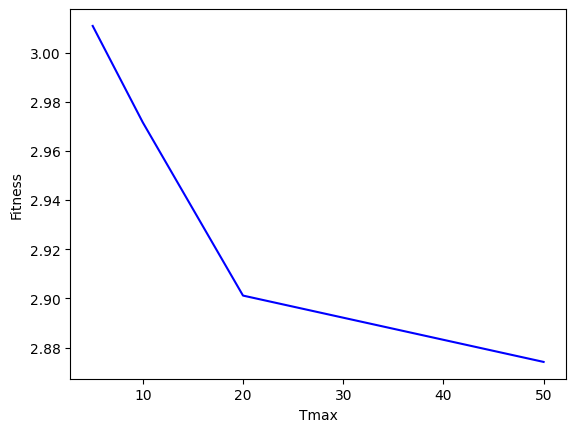

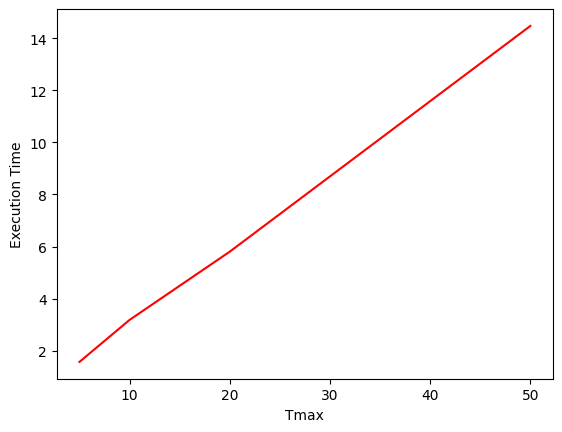

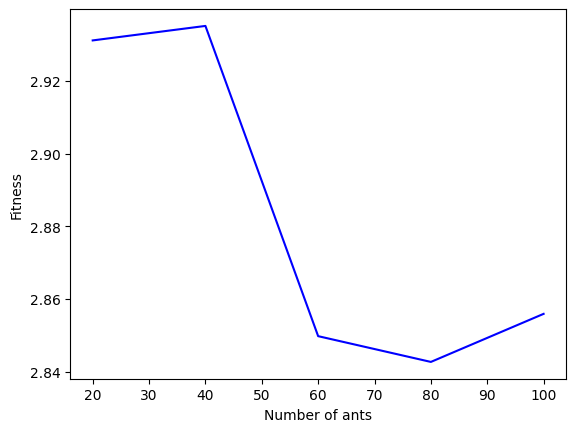

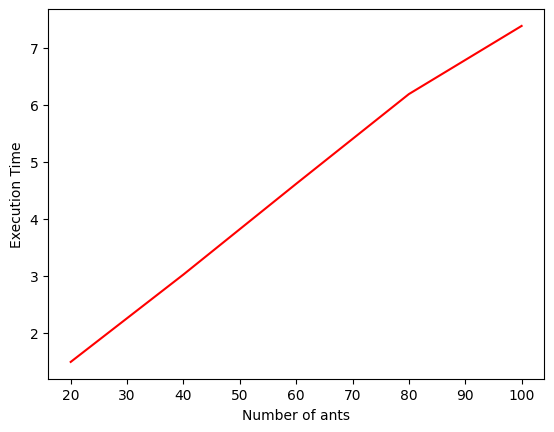

In [12]:
## Study effect of parameters, example on 'cities2.dat' file
dist = compute_distances(d_c2)
#run greedy once to get Lnn
path, g_fitness, exec_time = find_greedy(d_c2, dist)
# Tmax variation
compare_AS_tmax(d_c2, dist, g_fitness)
# Number of Ants variation
compare_AS_ants(d_c2, dist, g_fitness)

#### Comment on the results (effect of t_max & number of ants)

I arbitrarly fixed $t_{max}$ to 5 when we are looking at the effects of the number of ants and $m$ the number of ants to 20 when we look at the effects of $t_{max}$. We can see that both times the exectution time increase is linear.  
We can see that the more we increase $t_{max}$, the smaller the fitness is. The improvement is huge in the begining and then gets smaler (probably as we approche the optimal solution.  
For the number of ants we can see that the fitness is improved as we increase it until we reach $m = 80$ (which gives the best result). After that the fitnes start to increase slowly.

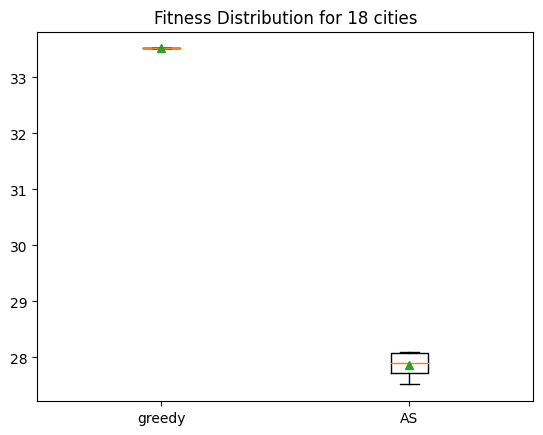

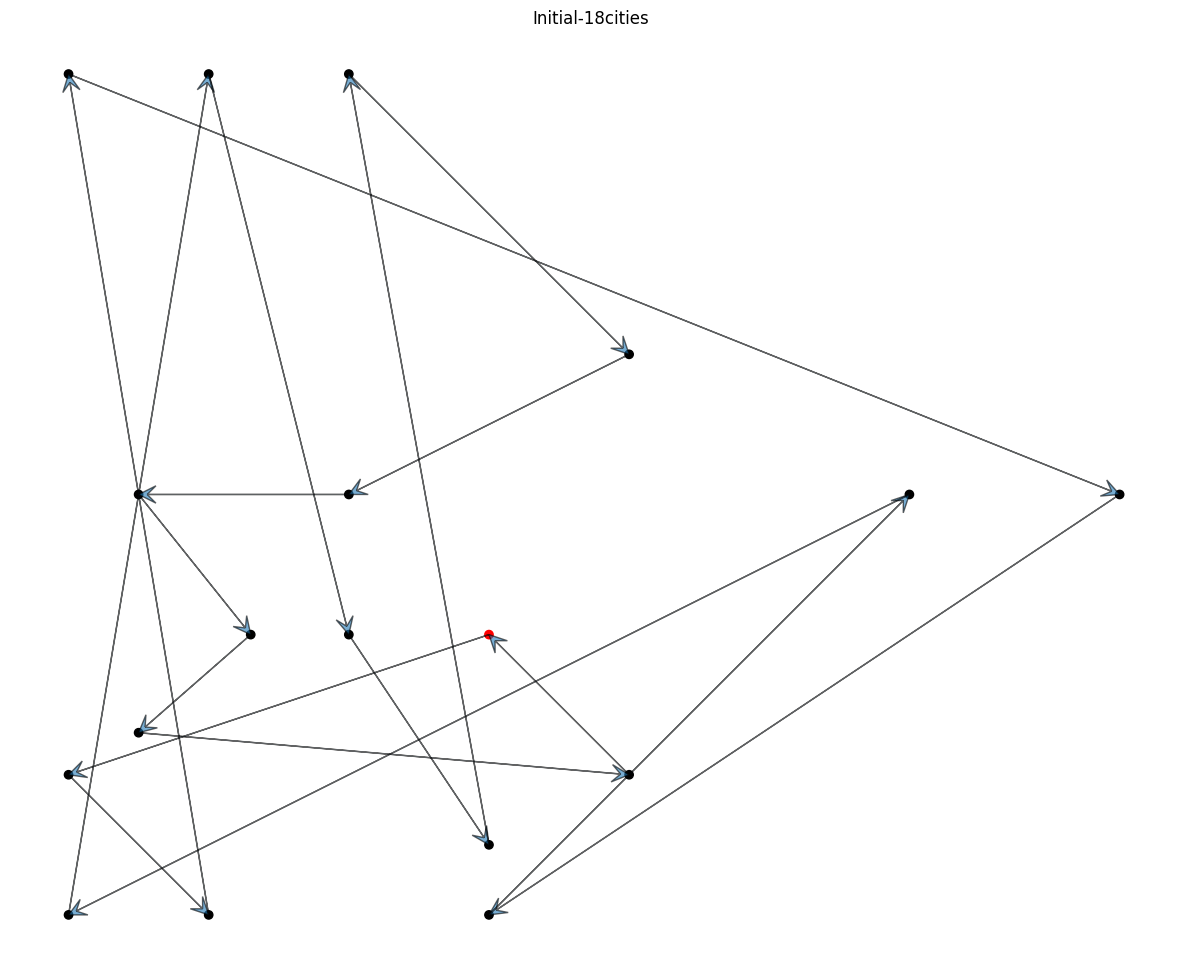

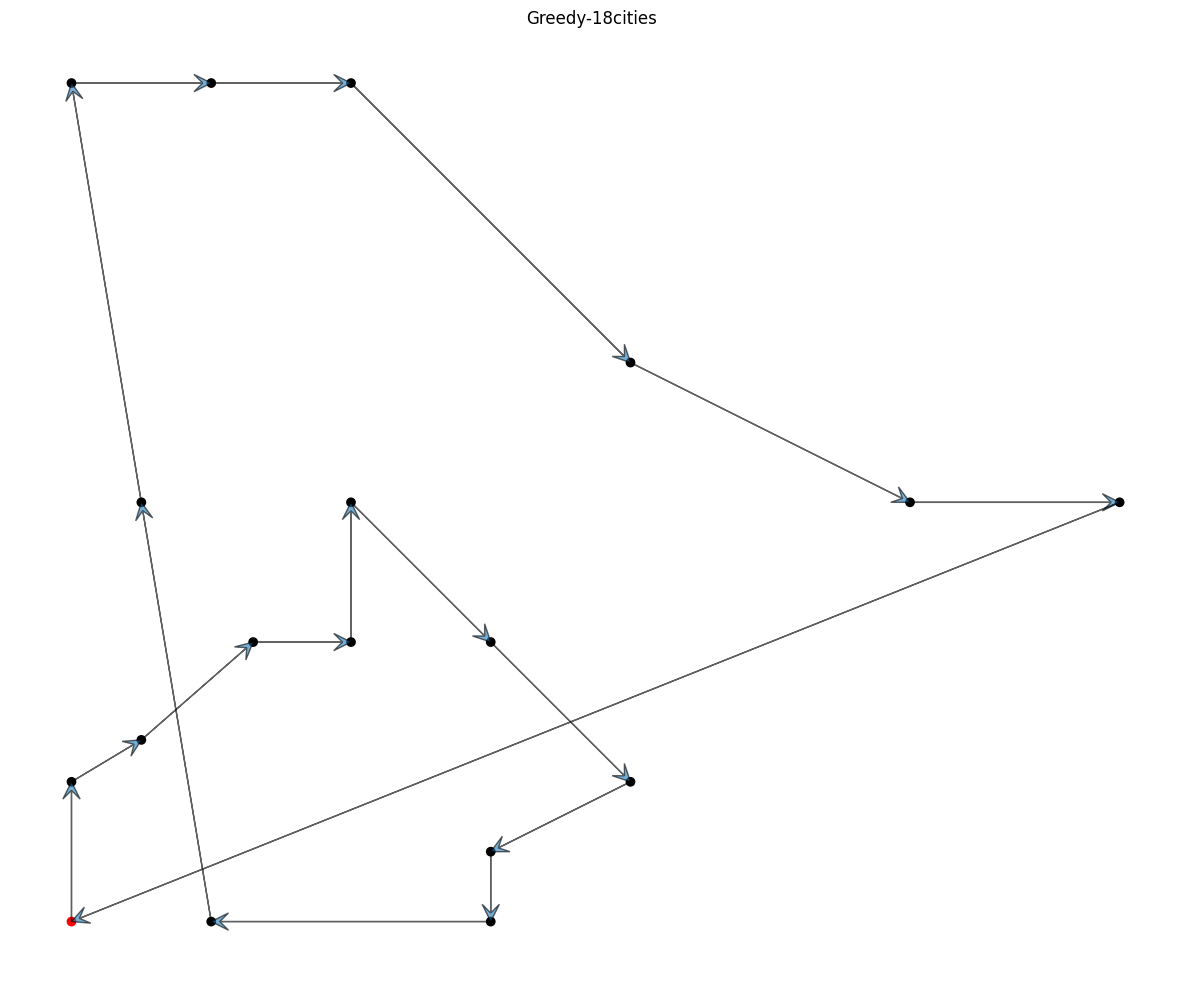

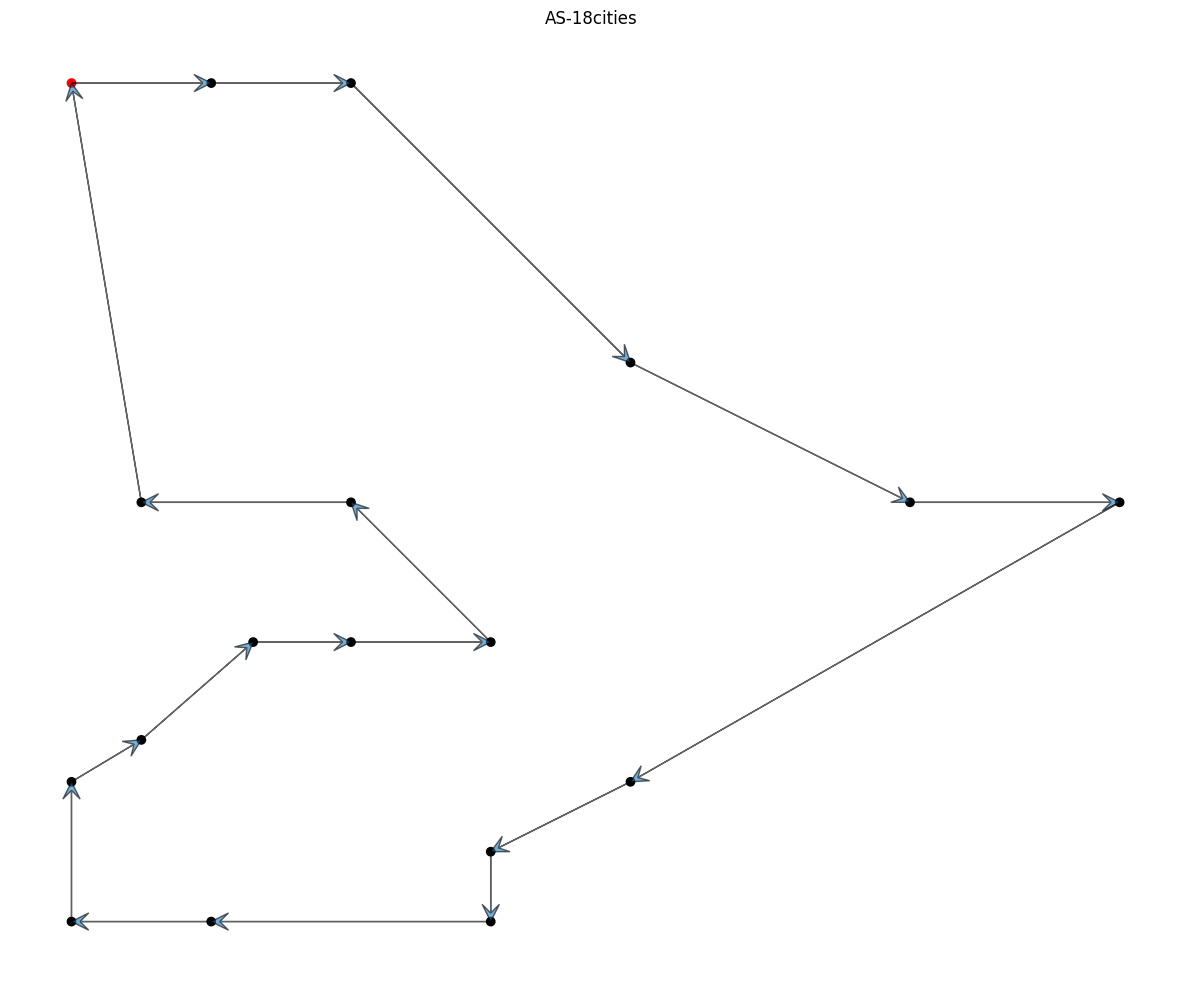

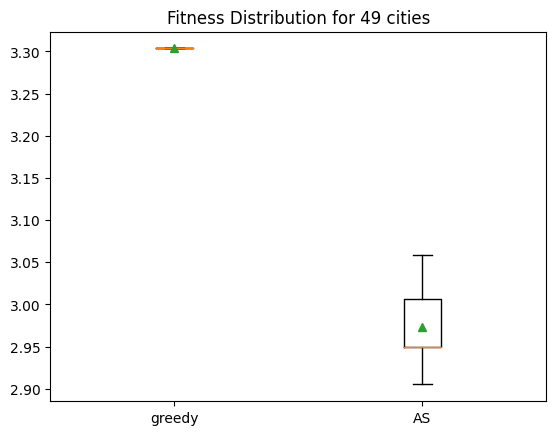

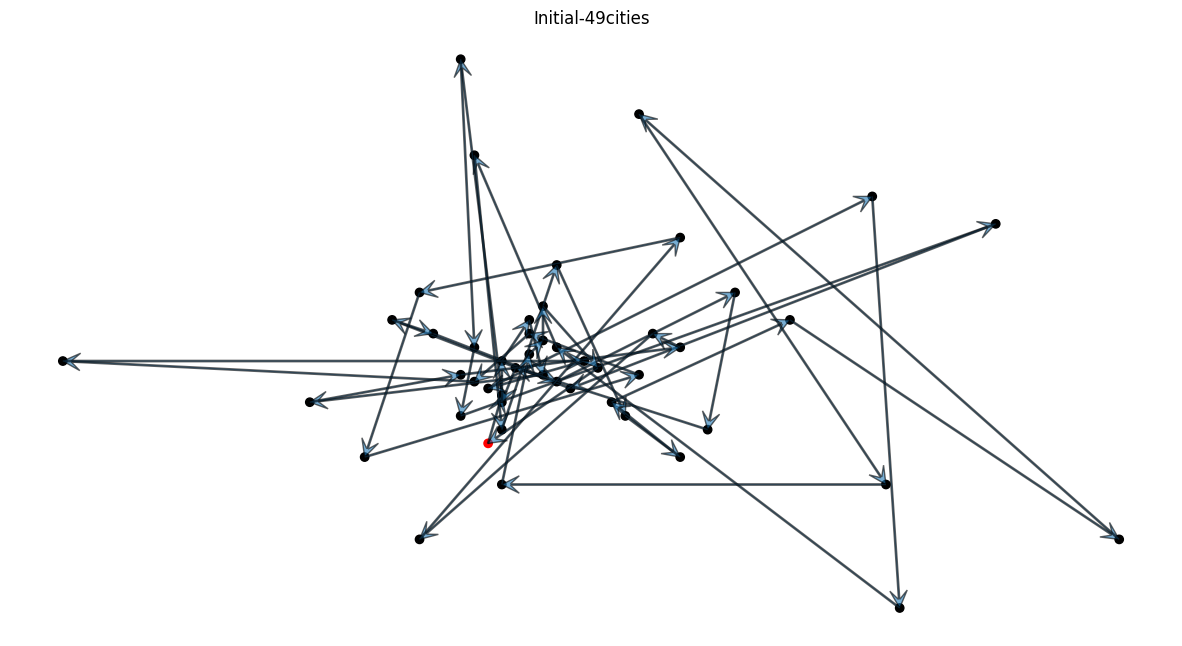

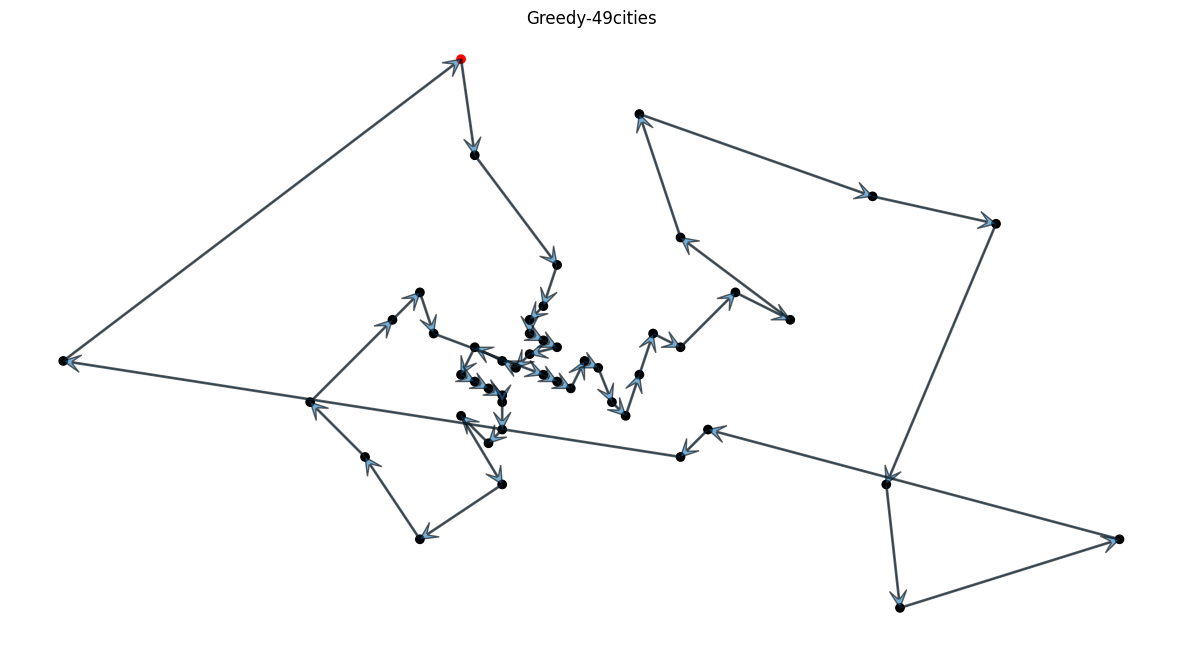

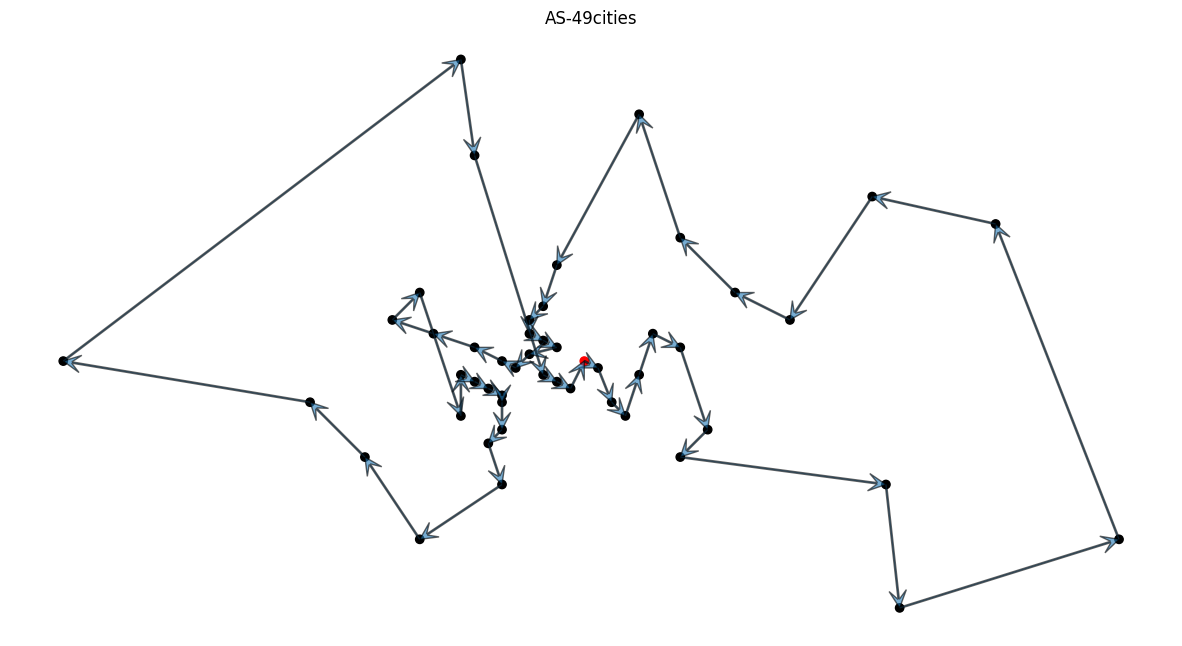

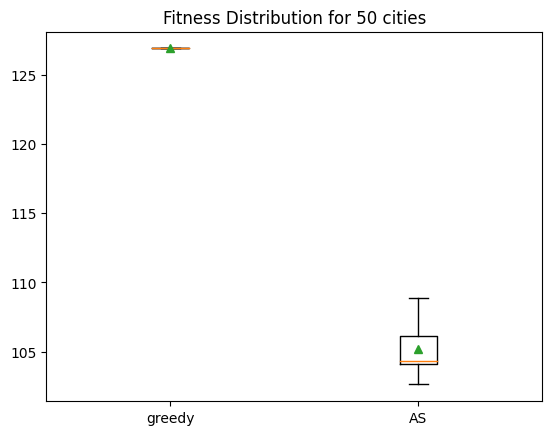

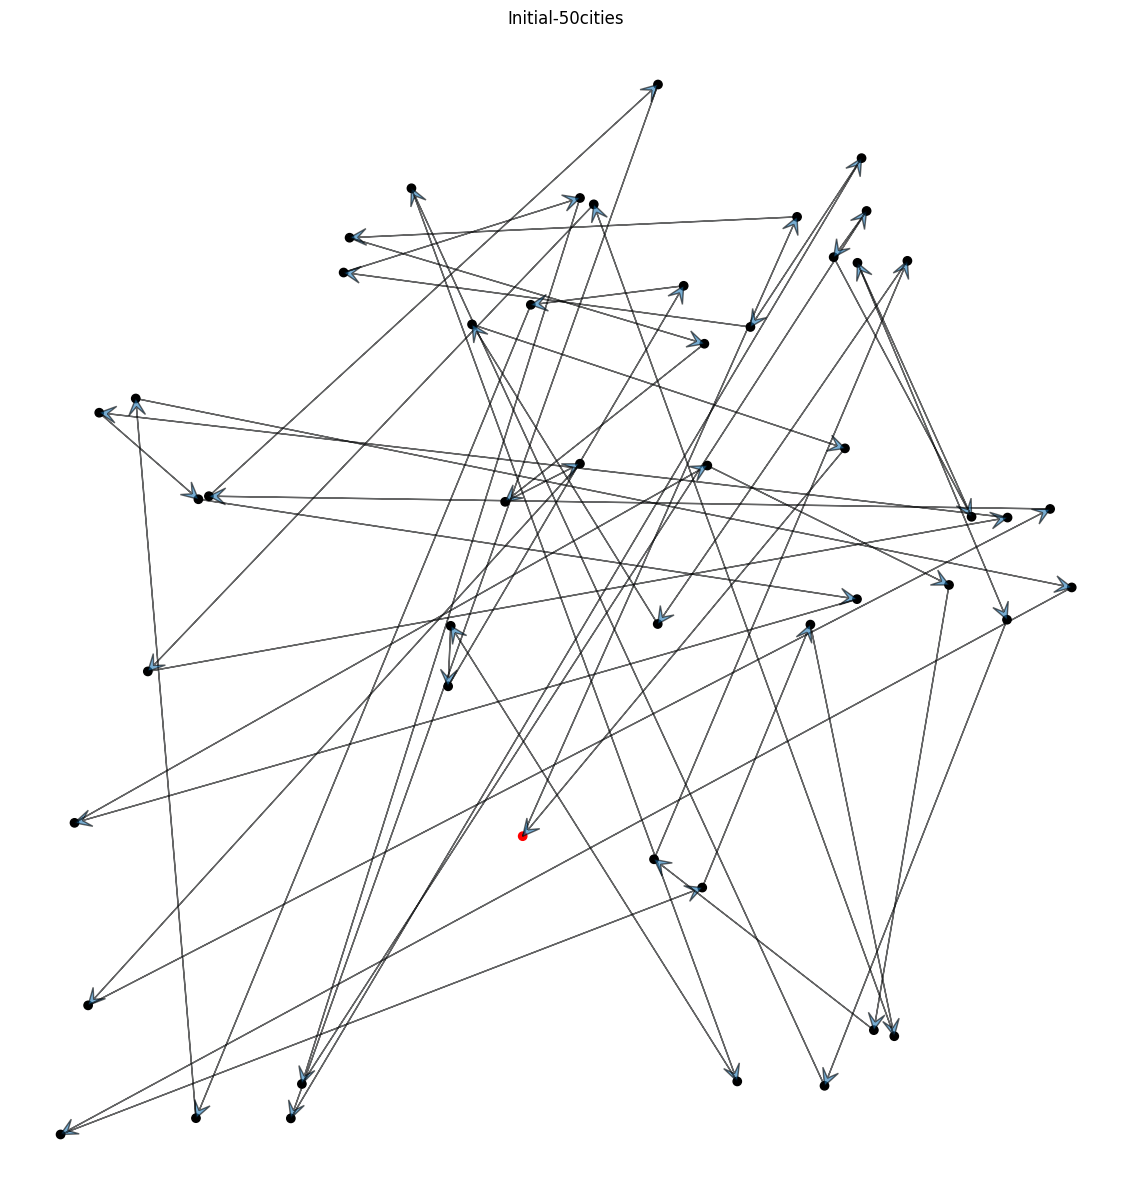

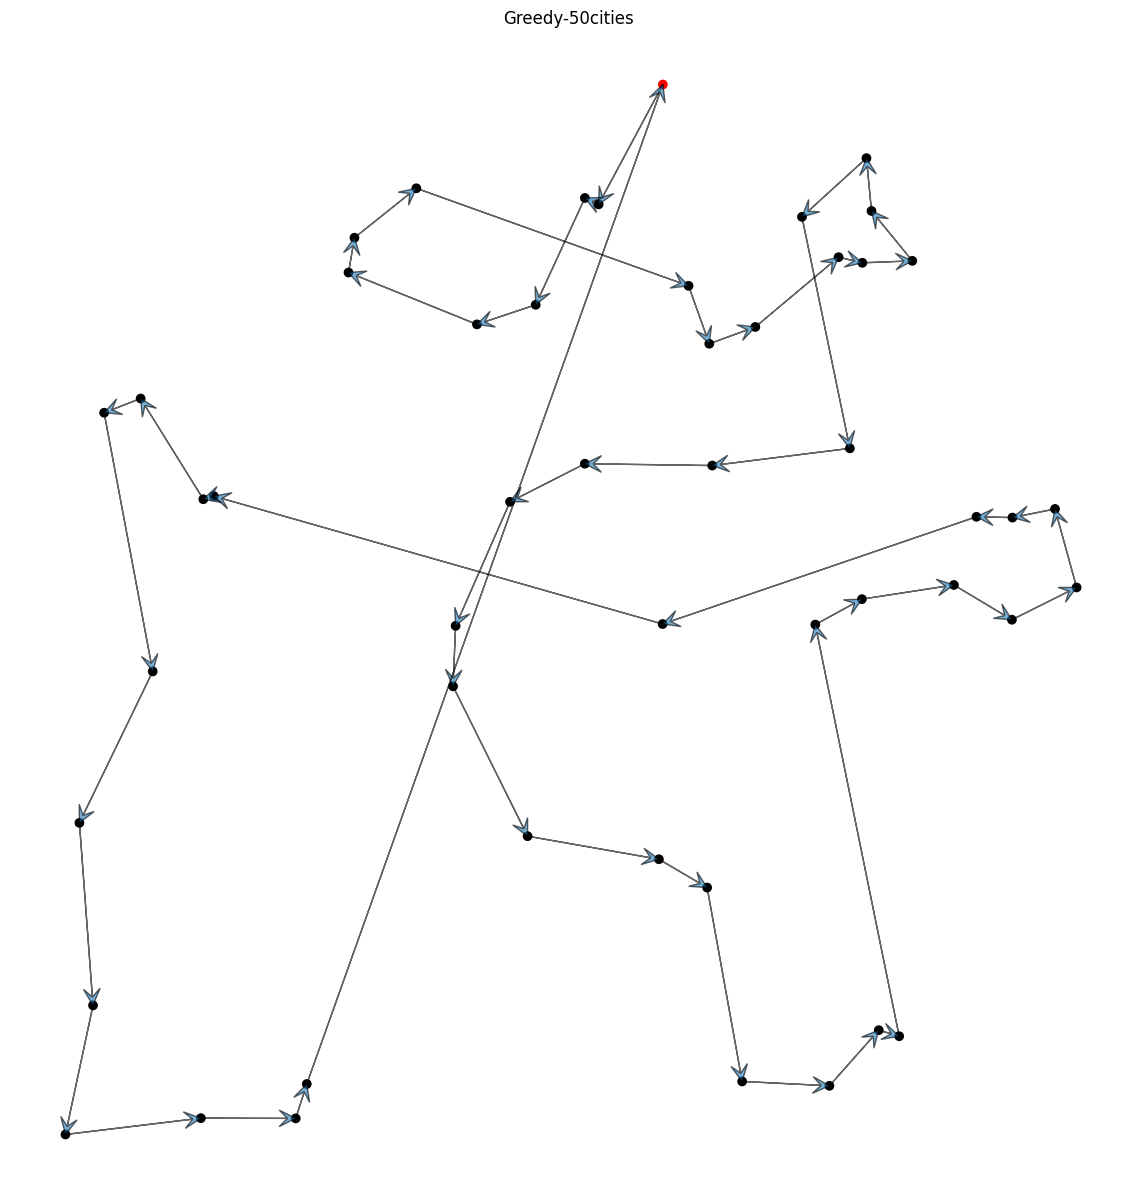

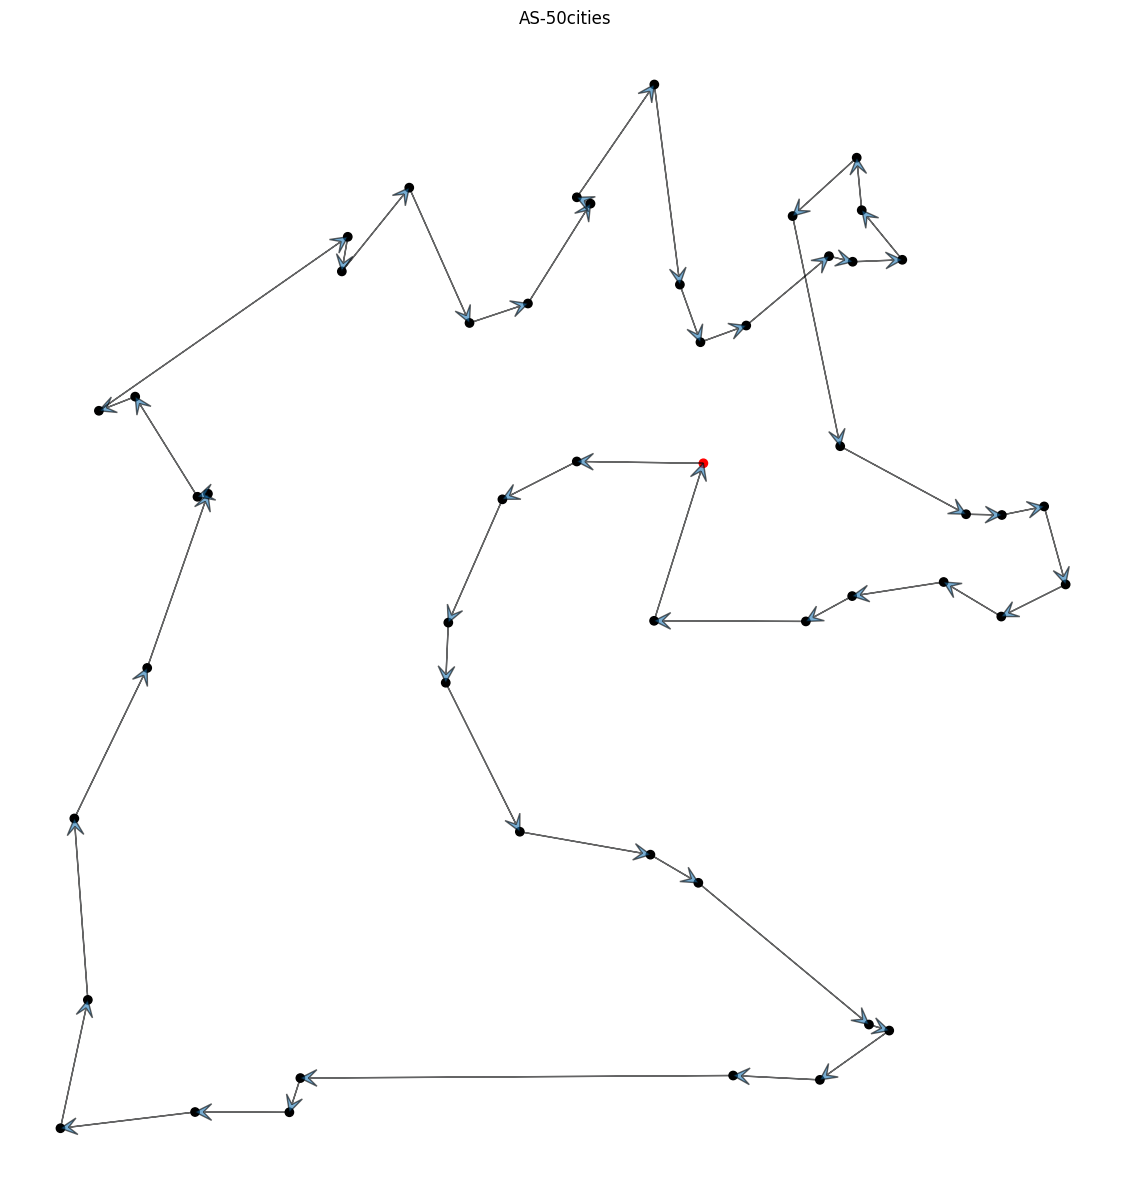

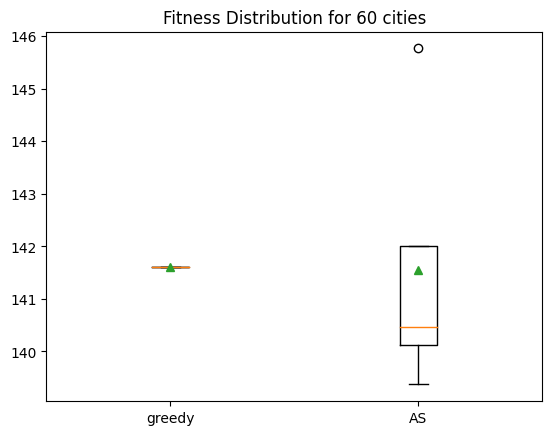

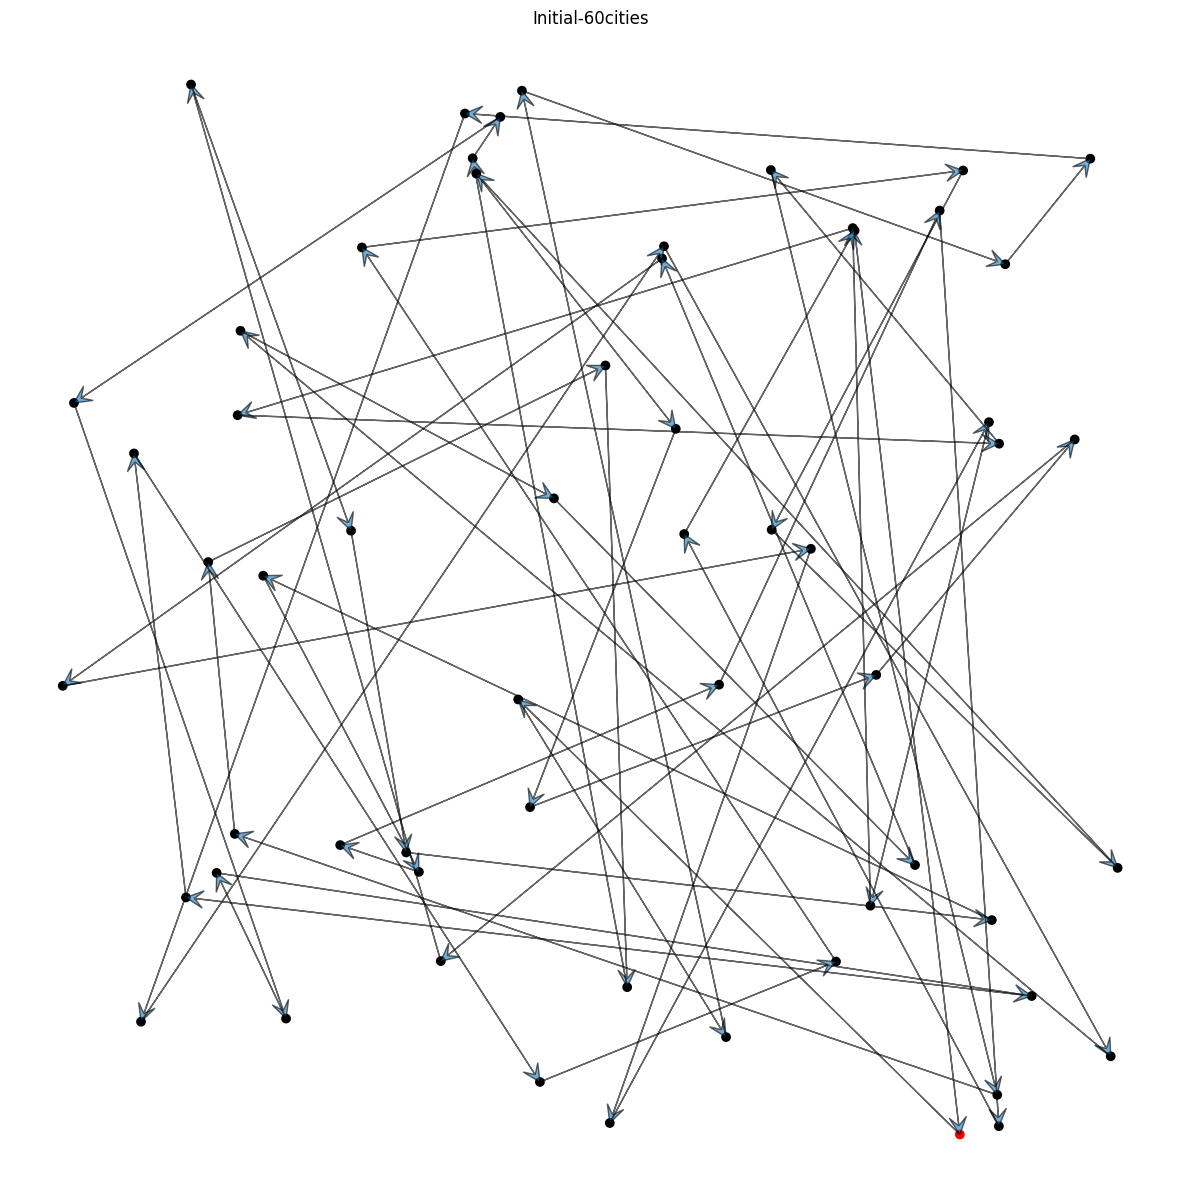

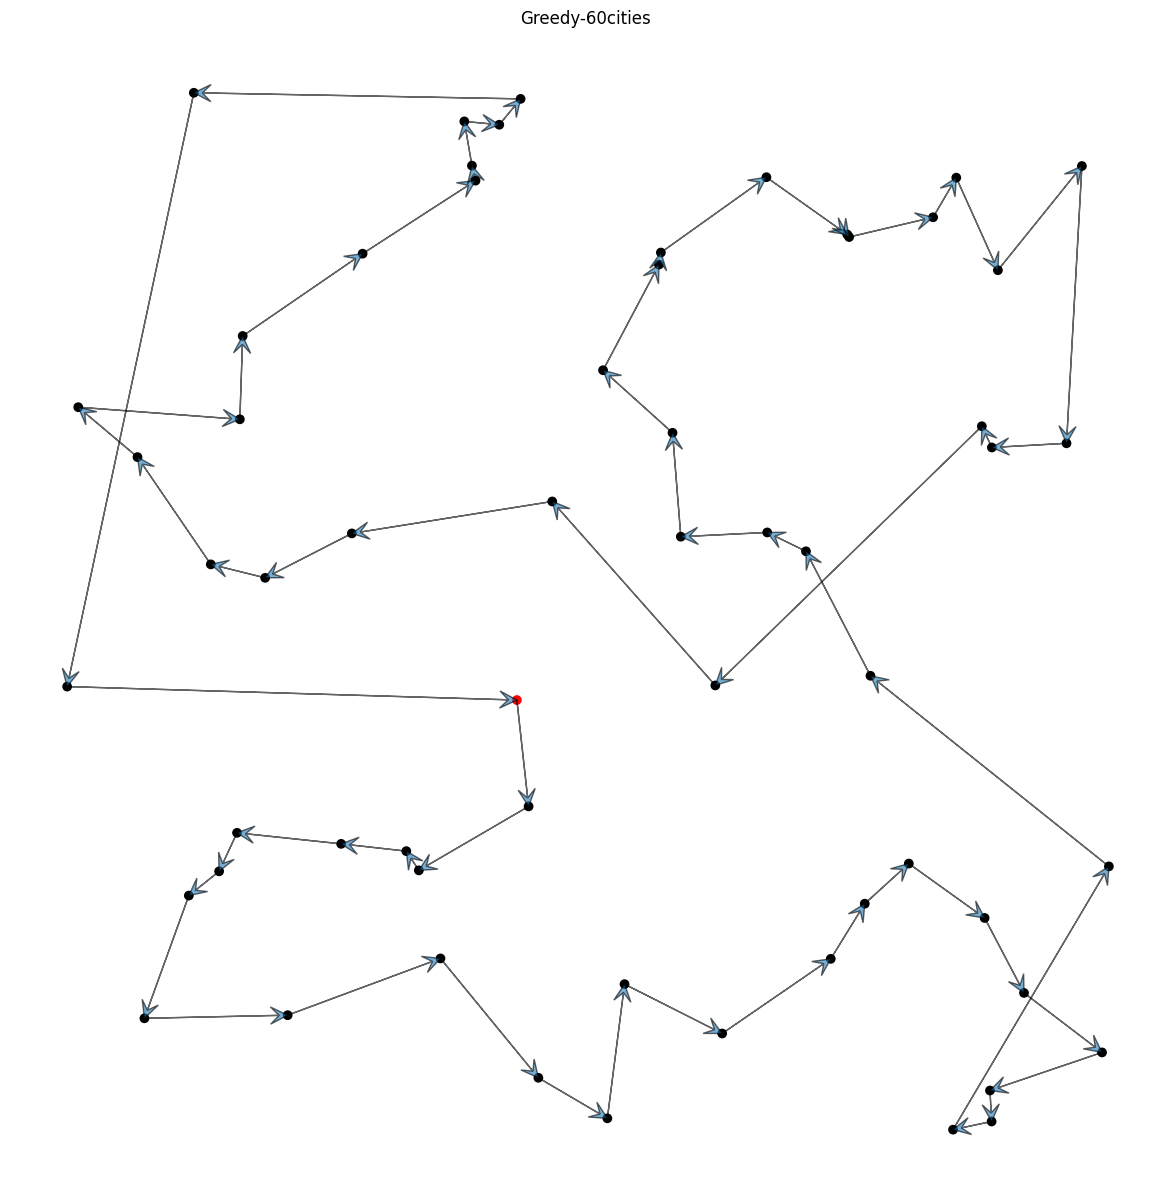

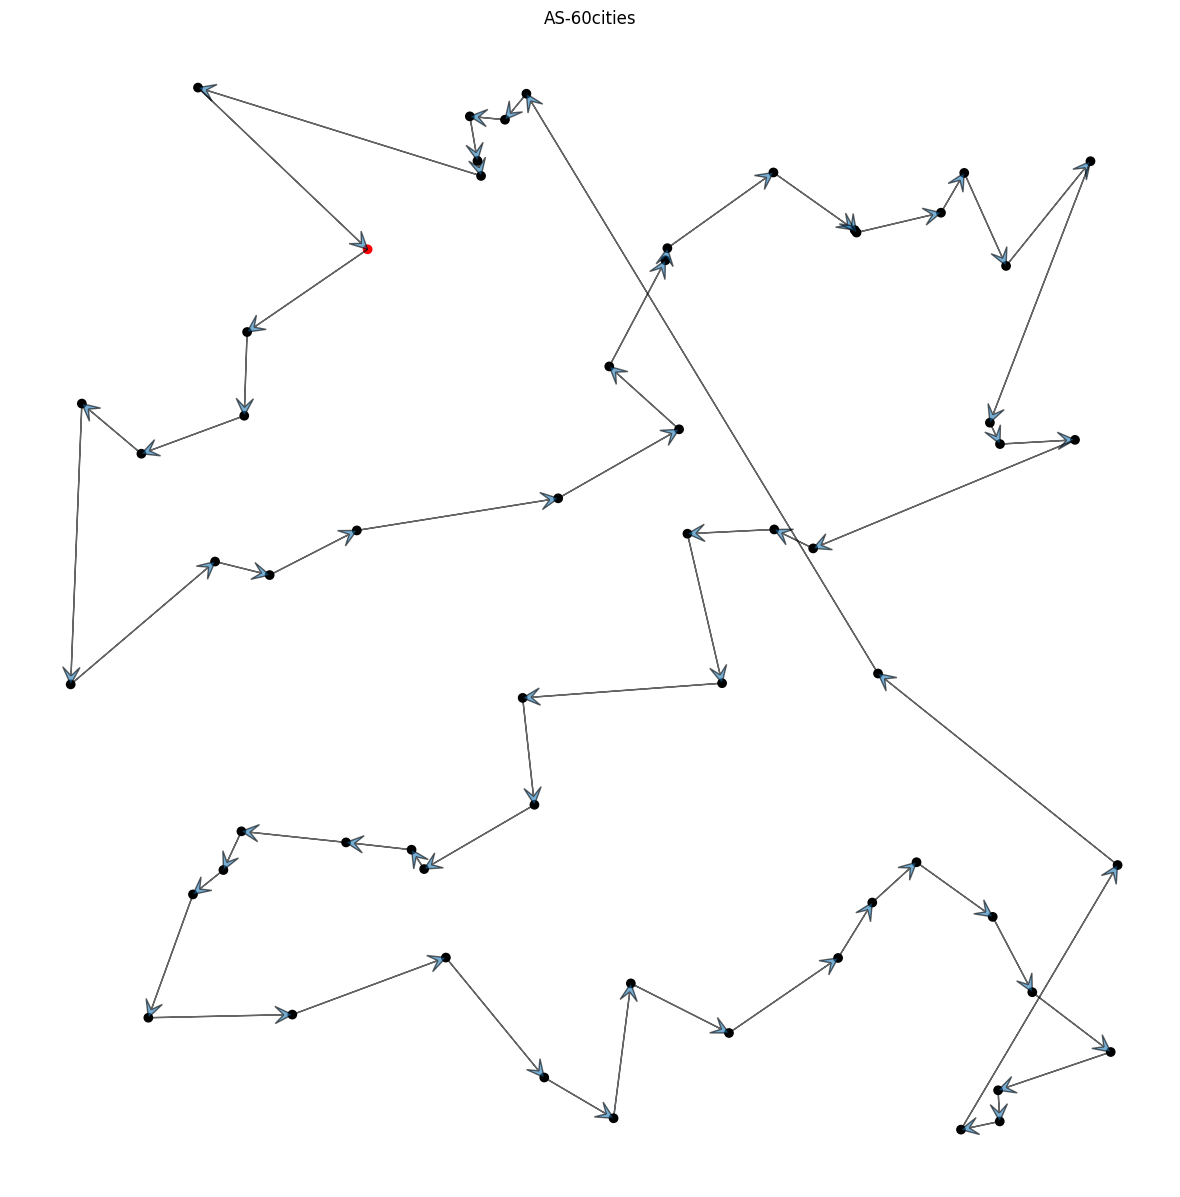

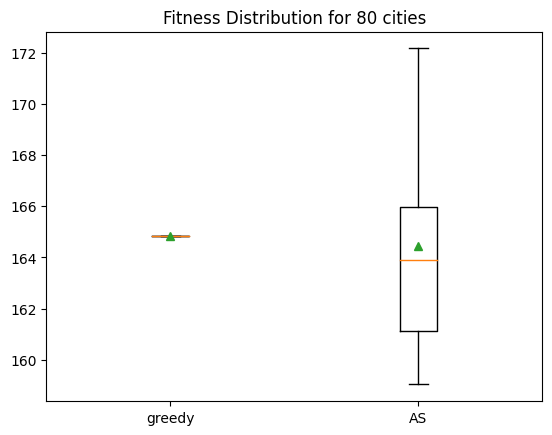

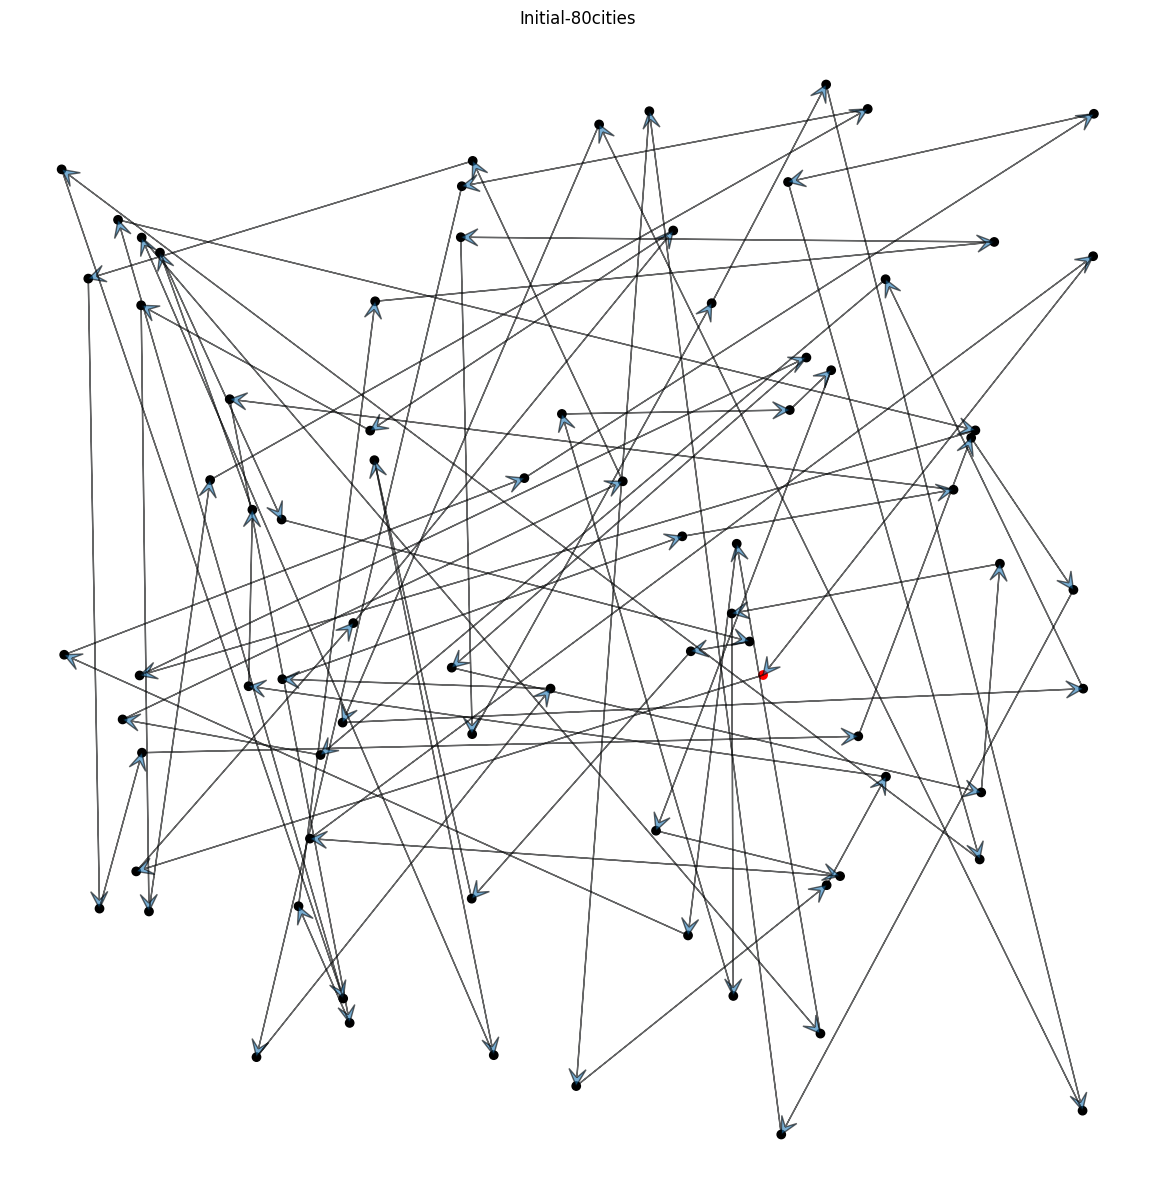

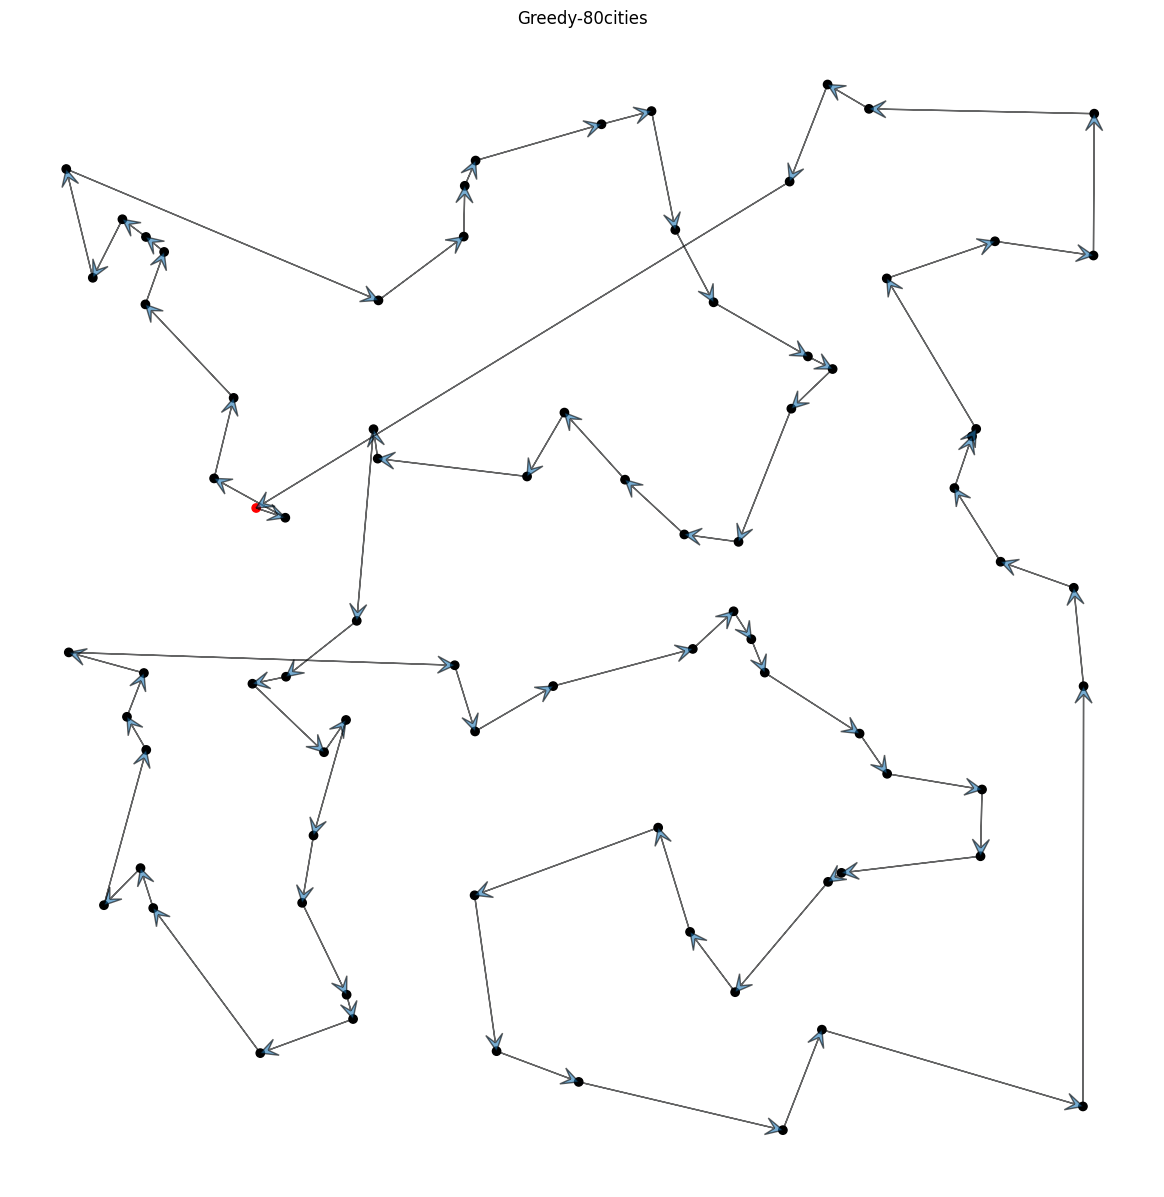

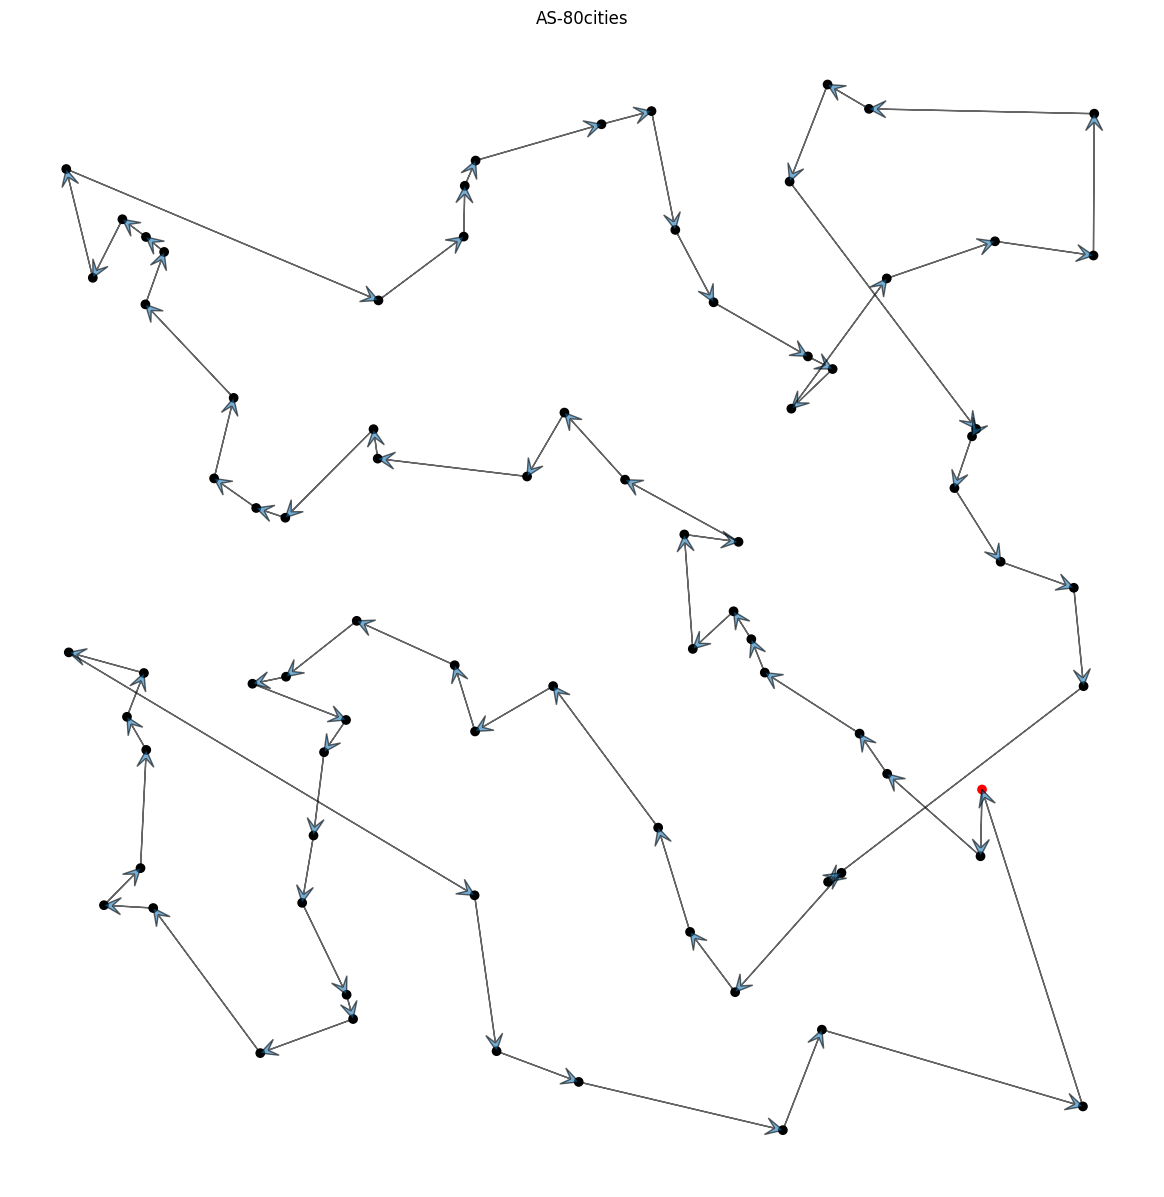

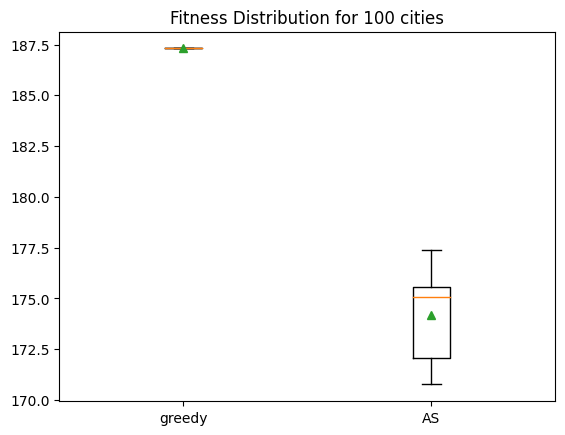

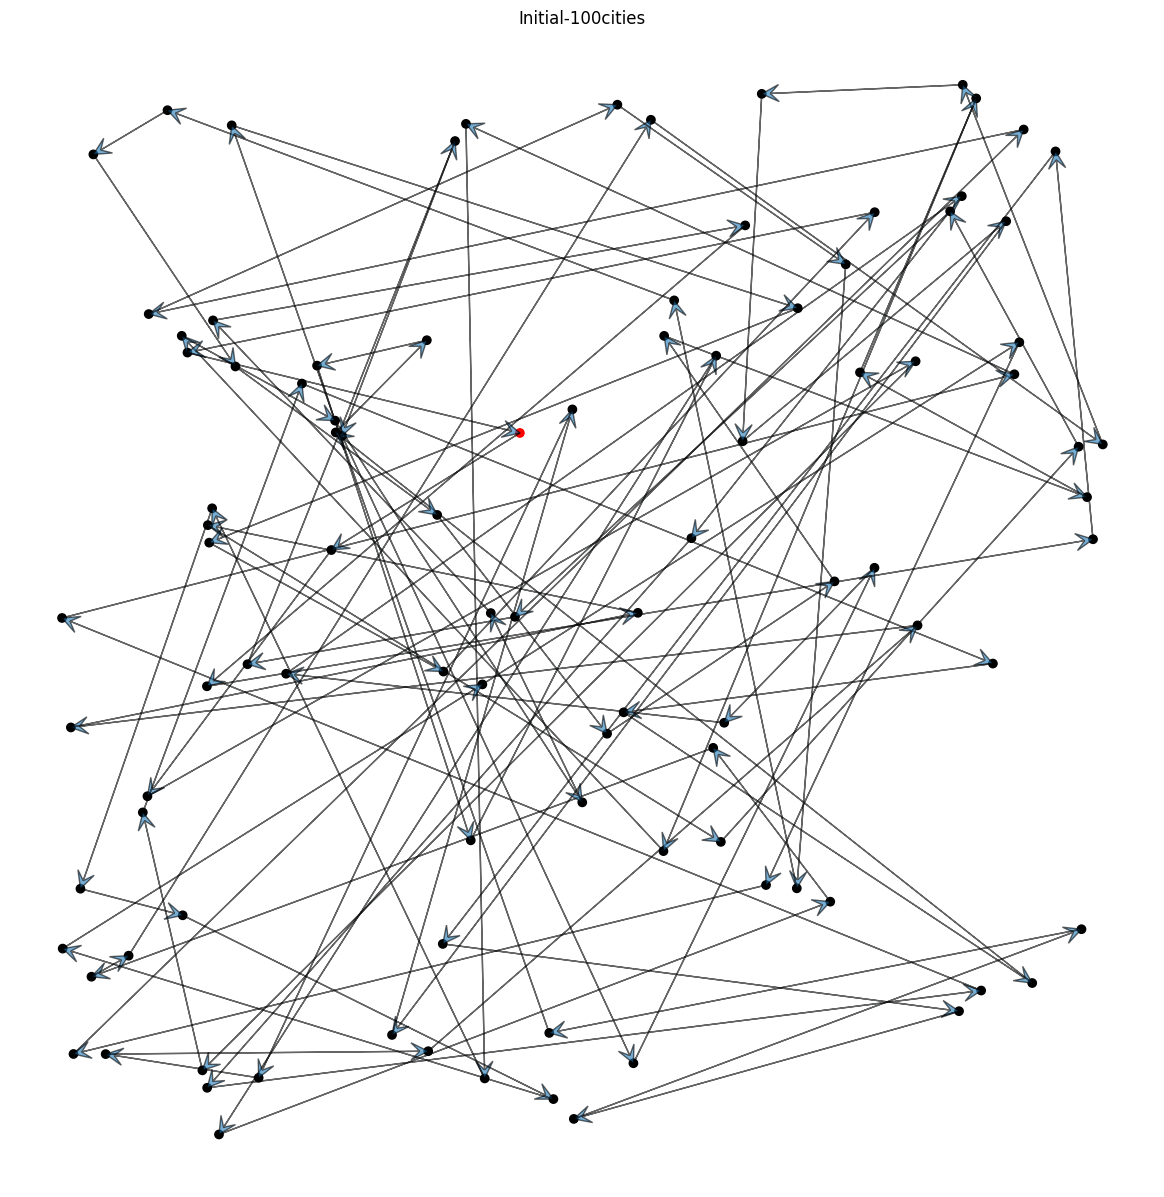

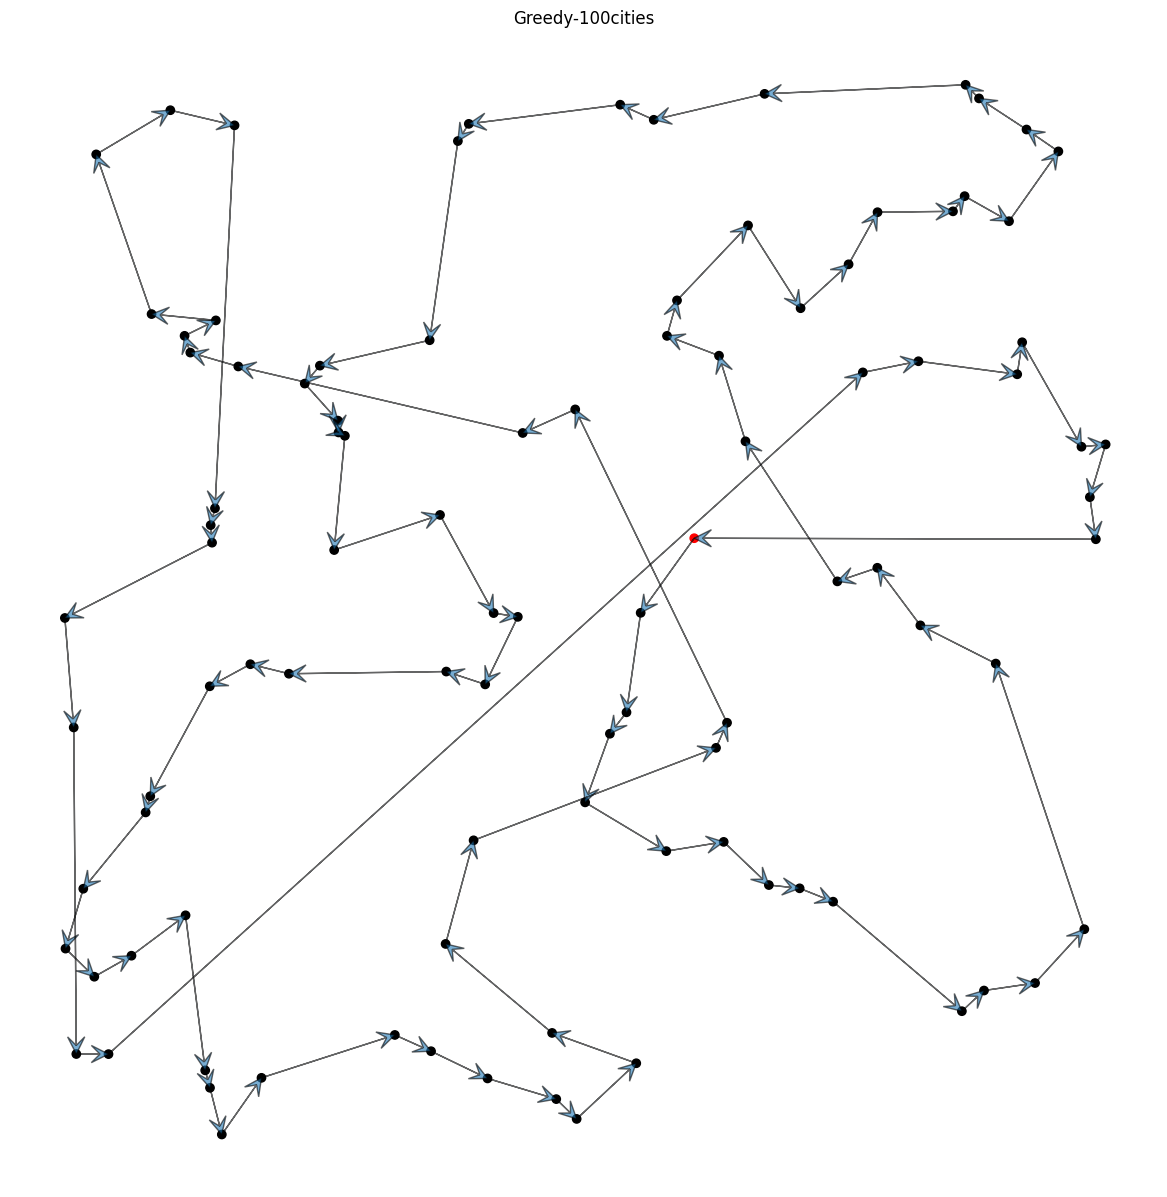

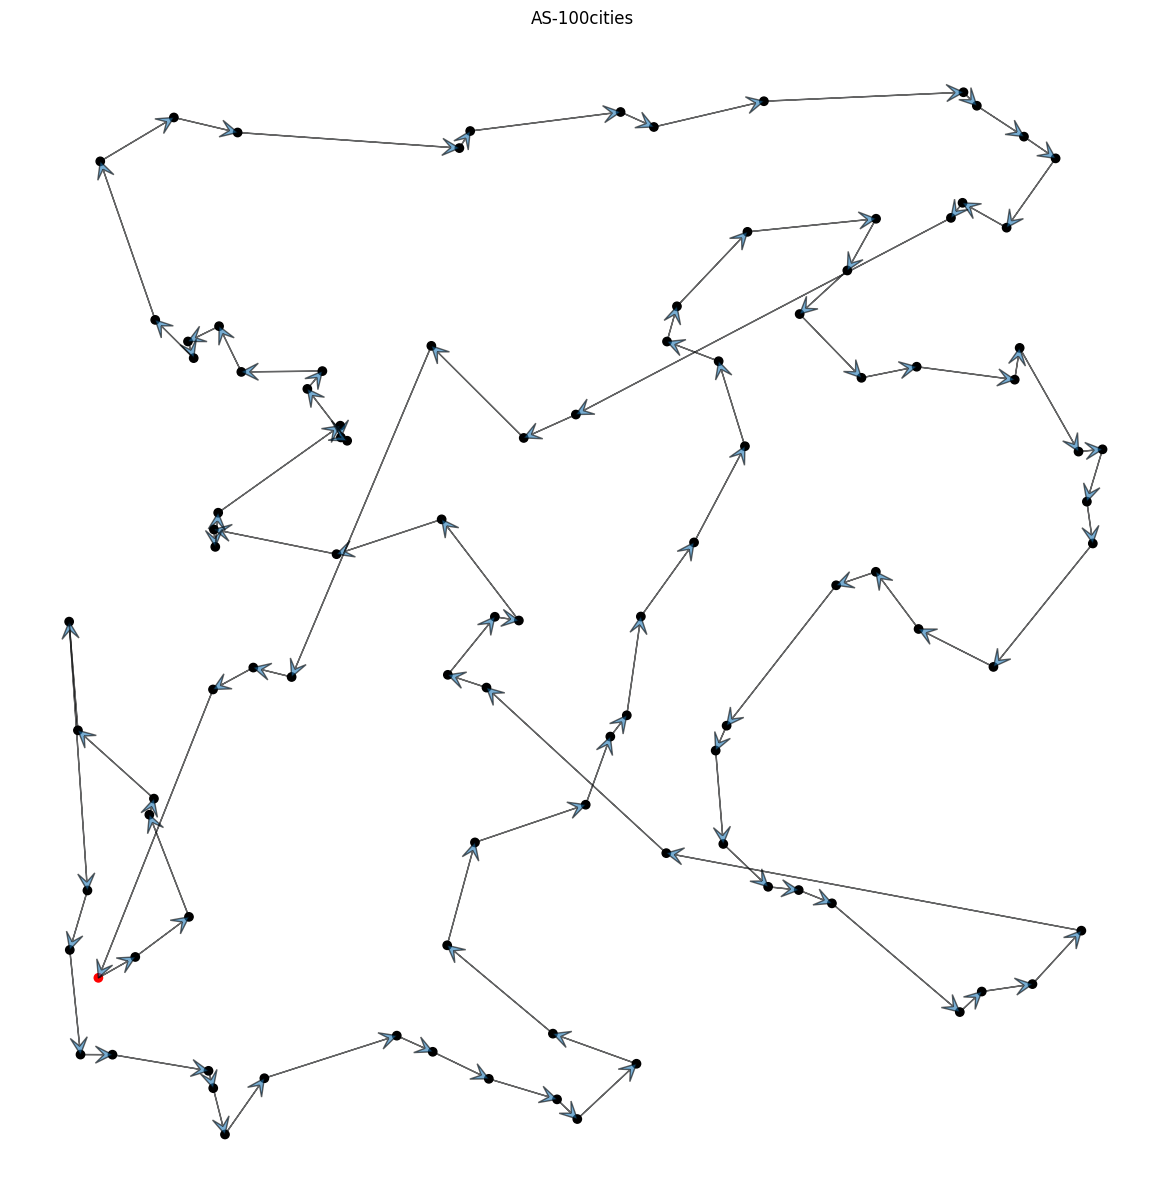

In [13]:
## compare greedy vs AS for 'cities.dat', 'cities2.dat', and 50, 60, 80, & 100 cities' configurations
compare_methods(setting=d_c1, filename="c1")
compare_methods(setting=d_c2, filename="c2")
for k in d_pt:
    compare_methods(setting=d_pt[k], filename=f'dpt_{k}')

#### Comment on the results for Ant System (AS) vs. Greedy

- Fitness :
The greedy algorithm always finds the same solution for a same problem because it will always do the same choices, since the ant system is probabilistic the solutions are not always the same for a same TSP problem. But we can see that for each number of cities the ant system finds better results than the greedy algorithm. Event the worst solution has a lower fitness than the greedy solution. We can also see that in all cases the mean of the finess for AS is higher than the best solution.
- Execution time :
As expected the ant system is much slower than the greedy algorithm (at least 10 000 times slower).  
We can conclude that even if the AS is much slower than the greedy algorithm it is a better option for the TSP. For problems of size 50, 60,80 and 100 we can even say that we don't need to run the AS several times to find a better solution (however it can still be interesting to do so since we could find an even better solution).

#### Compare and discuss the performance of the Ant System (AS) and the Simulated Annealing (SA) algorithms applied on the TSP in terms of their solution quality and execution time.

In the lat TP we saw that the SA needed to be runned a lot of times to have a good chance to find a better solution than the greedy one, even for problems of size 50 (and the more cities we have the more times we need to run it). Here we saw that the AS did better than the greedy algorithm every time.  
Both algorithm are much slower than the greedy algorithm. but when we compare the increase of computation time of both algorithm to the one for the greedy algorithm we can see that the SA computation time is growing much faster.  
We can conclude that the ant system is a better algorithm than the simulated annealing for TSP.

Answer the following Questions: 

1.  Q: What is the Search Space for Ant System algorithm? (given number of cities = n, & number of ants = m)

    A: The search space is $(S_{n})^{m}$ where $S_{n}$ is the set of possible permutations.


2.  Q: Can you describe the neighborhood in this case?

    A:  The neighborhood has no clear definition but we build the chosen neighbor at iteration $t$ based on the $m$ paths found in the iteration $t-1$ and theire quality.

3.  Q: Talk about the impact of parameters $\alpha$, $\beta$, & $\rho$

    A: From the the probability formula we can see that :  
    - $\alpha$ has an impact on the intensity of the edge between two cities (at an iteration $t$). Increasing its value will give mor weight to edges with a high value of pheromone. 
    - $\beta$ has an impact on the inverse of the distance between two cities. Increasing its value will give more weight to cities geographicaly close without taking into account the intensity of the edge. This will favorise the exploration of new paths.  
      
    The parameter $\rho$ represents the evaporation rate which has an impact on how much $\tau_{ij}(t)$ is taken into acount for $\tau_{ij}(t+1)$. Reducing it gives more wieght to $\tau_{ij}(t)$ and increases the risks to have a convergence to quickly and be stuck on a local optimum.
